#  Ананлиз данных о продажах компании 23andMe

https://platform.stratascratch.com/data-projects/sales-data-analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

Please answer the questions below based on the data provided:

    1. Plot daily sales for all 50 weeks.
    2. It looks like there has been a sudden change in daily sales. What date did it occur?
    3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
    4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers?     Please use plots to support your answer (a rigorous statistical analysis is not necessary).
    5. Assume a given day is divided into four dayparts:
        night (12:00AM - 6:00AM),
        morning (6:00AM - 12:00PM),
        afternoon (12:00PM - 6:00PM),
        evening (6:00PM - 12:00AM).
    What is the percentage of sales in each daypart over all 50 weeks?

## Загрузка и предобработка данных

In [2]:
# загрузим данные из файла csv 23andMe_dataset.csv
df = pd.read_csv('23andMe_dataset.csv')

In [3]:
# посмотрим на данные
df.head()

,purchaser_gender,sale_time
0,female,2012-10-01 01:42:22
1,female,2012-10-01 02:24:53
2,female,2012-10-01 02:25:40
3,female,2012-10-01 02:30:42
4,male,2012-10-01 02:51:32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203821 entries, 0 to 203820
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   purchaser_gender  203821 non-null  object
 1   sale_time         203821 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


В данных нет пропусков. Для удобства изменим имена столбцов, а также тип данных столбца *sale_time* на datetime.

In [5]:
# переименуем столбцы
df.rename({'purchaser_gender': 'gender', 'sale_time': 'datetime'}, axis = 'columns', inplace = True)

In [6]:
# изменим формат на datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,gender,datetime
0,female,2012-10-01 01:42:22
1,female,2012-10-01 02:24:53
2,female,2012-10-01 02:25:40
3,female,2012-10-01 02:30:42
4,male,2012-10-01 02:51:32


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203821 entries, 0 to 203820
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   gender    203821 non-null  object        
 1   datetime  203821 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 3.1+ MB


In [8]:
# для удобства дальнейшей работы и построения графиков добавим столбцы date и time, содержащие отдельно дату и время продажи
df['date'] = df['datetime'].dt.to_period("D").apply(str)
df['time'] = df['datetime'].apply(str).apply(lambda x: x[11:20])
df.head()

,gender,datetime,date,time
0,female,2012-10-01 01:42:22,2012-10-01,01:42:22
1,female,2012-10-01 02:24:53,2012-10-01,02:24:53
2,female,2012-10-01 02:25:40,2012-10-01,02:25:40
3,female,2012-10-01 02:30:42,2012-10-01,02:30:42
4,male,2012-10-01 02:51:32,2012-10-01,02:51:32


In [9]:
# информация о дате и времени наблюдений
print(f"Начальная дата: {df.datetime.min()}\nКонечная дата: {df.datetime.max()}\nРазница: {df.datetime.max() - df.datetime.min()}")

Начальная дата: 2012-10-01 01:42:22
Конечная дата: 2013-09-15 23:48:47
Разница: 349 days 22:06:25


## 1. Plot daily sales for all 50 weeks.

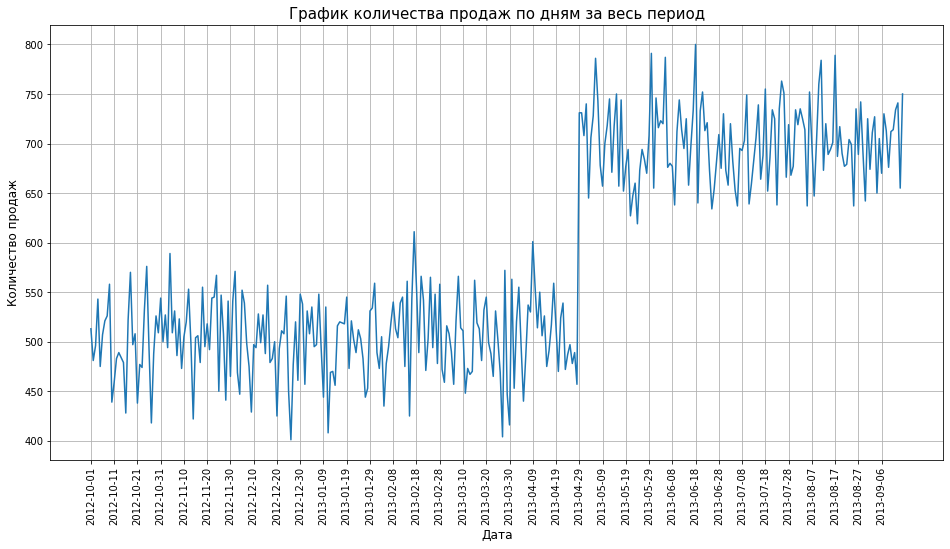

In [10]:
plt.figure(figsize = (16, 8))
sns.lineplot(x = df.groupby('date')['date'].count().index, y = df.groupby('date')['date'].count(), linewidth = 1.5)
plt.title('График количества продаж по дням за весь период', fontsize = 15)
plt.ylabel('Количество продаж', fontsize = 12)
plt.xlabel('Дата', fontsize = 12)
plt.grid()
plt.xticks(df['date'].unique()[ : :10], rotation = 90);

**Вывод:** по графику видно, что в конце апреля - начале мая произошел резкий рост количества продаж. Чтобы точно понять, в какой именно день был скачок, посмотрим на график количества продаж по дням за более короткий период. 

## 2. It looks like there has been a sudden change in daily sales. What date did it occur?

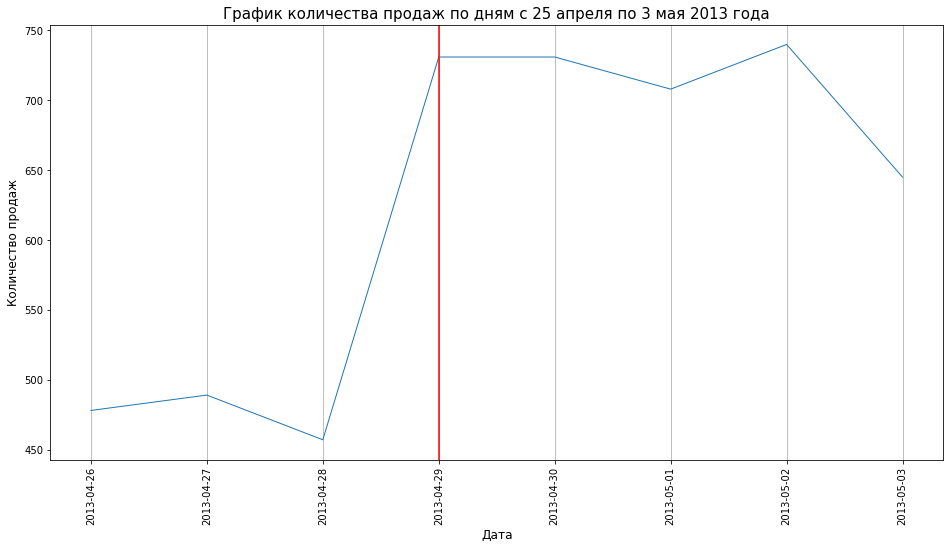

In [11]:
data = df[(df['date'] >= '2013-04-26') & (df['date'] <= '2013-05-03')].groupby('date')['date'].count()

plt.figure(figsize = (16, 8))
sns.lineplot(x = data.index, y = data, linewidth = 1)
plt.title('График количества продаж по дням с 25 апреля по 3 мая 2013 года', fontsize = 15)
plt.ylabel('Количество продаж', fontsize = 12)
plt.xlabel('Дата', fontsize = 12)
plt.xticks(rotation = 90)
plt.axvline('2013-04-29', color = 'red')
plt.grid(axis = 'x');

**Вывод:** скачок в количестве дневных продаж произошел **29 апреля 2013 года.**

In [12]:
change_date = '2013-04-29'

## 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

Чтобы оценить, являются ли различия в дневных продажах за периоды до и после 29 апреля 2013 года статистически значимыми, разобьем данные на две группы до и после указанной даты и с помощью статистического теста проверим значимость различий.

In [13]:
# сформируем группы
before = df[df['date'] < change_date].groupby('date')['date'].count()
after = df[df['date'] >= change_date].groupby('date')['date'].count()

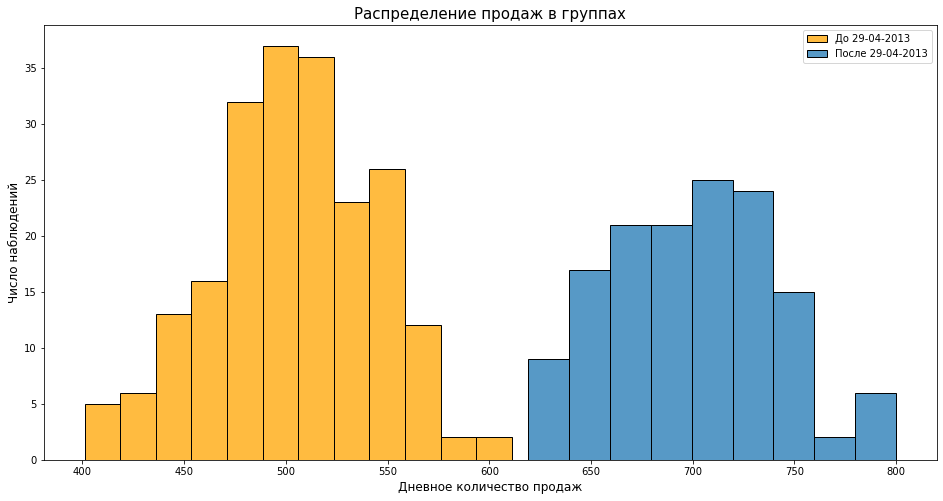

In [14]:
plt.figure(figsize = (16, 8))
sns.histplot(before, color = 'orange', label = 'До 29-04-2013')
sns.histplot(after, label = 'После 29-04-2013')
plt.title('Распределение продаж в группах', fontsize = 15)
plt.ylabel('Число наблюдений', fontsize = 12)
plt.xlabel('Дневное количество продаж', fontsize = 12)
plt.legend();

Уже по графику видно, что различия, вероятнее всего, не случайны, так как распределения групп слишком далеки друг от друга. 

Определимся со статистическим тестом, с помощью которого будем оценивать значимость различий в группах. Для этого проверим выполнение предпосылок, позволяющих использовать параметрический тест.

### Критерий Шапиро-Уилка для проверки нормальности распределения данных в каждой из групп

**alpha = 0.05**

**H0:** данные в группе распределены по нормальному закону.

**H1:** данные в группе не распределены по нормальному закону.

In [15]:
stats.shapiro(before)

ShapiroResult(statistic=0.9946988821029663, pvalue=0.6711584329605103)

In [16]:
stats.shapiro(after)

ShapiroResult(statistic=0.984731137752533, pvalue=0.12202926725149155)

Для обеих групп **pvalue > alpha**, поэтому на уровне значимости alpha = 0.05 **не отвергаем H0**.

Так как данные в группах распределены по нормальному закону, необходимо также проверить равенство дисперсий в группах.

### Критерий Бартлетта для проверки равенства дисперсий в группах 

Поскольку данные в группах распределены по нормальному закому, для проверки равенства диперсий будем использовать параметрический критерий Бартлетта.

**alpha = 0.05**

**H0:** выборки получены из генеральных совокупностей с равными дисперсиями.

**H1:** выборки получены из генеральных совокупностей с неравными дисперсиями.

In [17]:
stats.bartlett(before, after)

BartlettResult(statistic=0.0481116740867747, pvalue=0.8263822956750388)

Так как **pvalue > alpha**, на уровне значимости alpha = 0.05 **не отвергаем H0**.

Предпосылки о нормальности распеределния данных и равенстве диперсий в группах выполнены, но неизвестны среднеквадратические отклонения генеральных совокупностей, их которых взяты выброки. Поэтому для проверки статистической значимости различий в группах будем использовать **t-критерий Стьюдента**.

### t-критерий Стьюдента для проверки равенства средних в двух группах

**alpha = 0.05**

**H0:** средние значения в обеих группах равны.

**H1:** средние значения в группах разные.

In [18]:
stats.ttest_ind(before, after)

Ttest_indResult(statistic=-45.907882352999714, pvalue=1.0309146254384802e-149)

Так как **pvalue < alpha**, на уровне значимости alpha = 0.05 **отвергаем H0**.

Таким образом, можно утверждать, что различия в дневных продажах за периоды до и после 29 апреля 2013 года являются статистически значимыми (**pvalue=1.0309146254384802e-149**).

## 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers?     Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [19]:
# разобъем данные на две группы по полу
m = df[df['gender'] == 'male'].groupby('date')['date'].count()    # мужчины
f = df[df['gender'] == 'female'].groupby('date')['date'].count()     # женщины

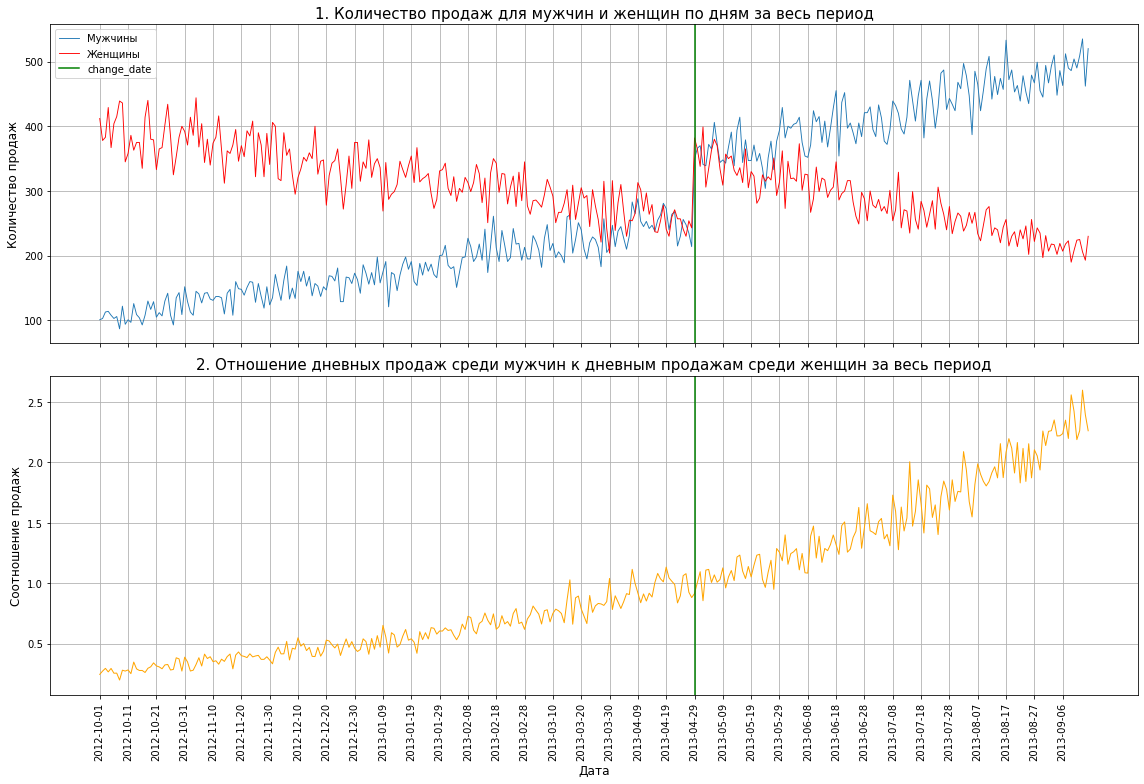

In [20]:
plt.figure(figsize = (16, 11))

plt.subplot(2, 1, 1)
sns.lineplot(x = m.index, y = m, linewidth = 0.9, label = 'Мужчины')
sns.lineplot(x = f.index, y = f, linewidth = 0.9, label = 'Женщины', color = 'red')
plt.title('1. Количество продаж для мужчин и женщин по дням за весь период', fontsize = 15)
plt.ylabel('Количество продаж', fontsize = 12)
plt.xlabel('', fontsize = 1)
plt.grid()
plt.xticks(df['date'].unique()[ : :10], labels = '')
plt.axvline('2013-04-29', color = 'green', label = 'change_date')
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(x = m.index, y = m / f, linewidth = 1, color = 'orange')
plt.title('2. Отношение дневных продаж среди мужчин к дневным продажам среди женщин за весь период', fontsize = 15)
plt.ylabel('Соотношение продаж', fontsize = 12)
plt.xlabel('Дата', fontsize = 12)
plt.grid()
plt.xticks(df['date'].unique()[ : :10], rotation = 90)
plt.axvline('2013-04-29', color = 'green')
plt.tight_layout();

**Вывод:** 
- по первому графику видно, что *на протяжении всего периода времени* дневное количество продаж среди мужчин росло, а среди женщин снижалось. При этом, когда число дневных продаж для мужин и женщин достигло одинакового уровня, произошел примерно равный рост продаж у мужчин и женщин. 

- по второму графику видно, что в дату роста дневных продаж не было существенного изменения соотношения продаж у мужчин и женщин, то есть **рост дневных продаж не связан с изменением соотношения продаж среди мужчин и женщин**.

- как уже было отмечено, рост продаж у мужчин и женщин (и, соответственно, общий рост) произошел, когда число дневных продаж для мужин и женщин достигло примерно одинакового уровня. Однако утверждать, что именно это стало причиной роста, имеющиеся данные не позволяют.

## What is the percentage of sales in each daypart over all 50 weeks?

In [21]:
# функция, принимающая на вход время в формате HH:MI:SS и возвращающая соответствующее время суток

def daypart(time):
    if '00:00:00' <= time < '06:00:00':
        return 'night'
    elif '06:00:00' <= time < '12:00:00':
        return 'morning'
    elif '12:00:00' <= time < '18:00:00':
        return 'afternoon'
    else:
        return 'evening'

In [22]:
# добавим столбец времени суток
df['daypart'] = df['time'].apply(daypart)
df.sample(15)

,gender,datetime,date,time,daypart
199843,male,2013-09-10 12:57:54,2013-09-10,12:57:54,afternoon
194943,male,2013-09-03 12:05:08,2013-09-03,12:05:08,afternoon
196583,male,2013-09-05 17:57:13,2013-09-05,17:57:13,afternoon
67856,female,2013-02-13 11:29:27,2013-02-13,11:29:27,morning
106157,female,2013-04-29 15:33:53,2013-04-29,15:33:53,afternoon
67717,female,2013-02-13 04:49:32,2013-02-13,04:49:32,night
44235,male,2012-12-28 08:50:08,2012-12-28,08:50:08,morning
58885,female,2013-01-26 12:57:17,2013-01-26,12:57:17,afternoon
152904,female,2013-07-05 13:10:46,2013-07-05,13:10:46,afternoon
160158,female,2013-07-16 02:39:11,2013-07-16,02:39:11,night


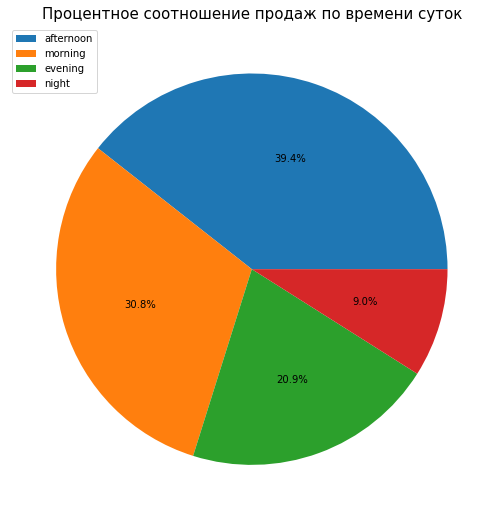

In [23]:
plt.figure(figsize = (9, 9))
plt.pie(df['daypart'].value_counts().values, autopct='%1.1f%%')
plt.legend(df['daypart'].value_counts().index)
plt.title('Процентное соотношение продаж по времени суток', fontsize = 15);

In [24]:
round(df['daypart'].value_counts(normalize = True) * 100, 2)

afternoon    39.39
morning      30.76
evening      20.88
night         8.97
Name: daypart, dtype: float64

**Вывод:** больше всего продаж (39.4 %) происходит после полудня, а меньше всего (9 %) - ночью.